In [1]:
from langchain_openai import ChatOpenAI
from langchain_anthropic import ChatAnthropic

import os
import getpass
os.environ['OPENAI_API_KEY'] = ""
os.environ['ANTHROPIC_API_KEY'] = ""

In [2]:
def add(a: int, b: int):
    """Adds two numbers"""
    return a + b

In [3]:
def multiply(a: int, b: int):
    """Multiplies two numbers"""
    return a * b

### Wrapper for a single agent that can both call tools and transfer to other agents

In [4]:
from langgraph.prebuilt.chat_agent_executor import AgentRouterState
from langgraph.prebuilt import create_react_agent

In [5]:
model = ChatOpenAI(model="gpt-4o")

In [6]:
model_anthropic = ChatAnthropic(model="claude-3-5-sonnet-latest")

In [7]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, GraphCommand, START, END
from typing import Literal

In [8]:
from langgraph.prebuilt.handoff import create_handoff_tool, GraphCommandTool

In [9]:
from langchain_core.runnables import RunnableConfig

In [10]:
from langchain_core.messages import HumanMessage

In [11]:
from typing import Callable

In [12]:
# output processors

def keep_last_message_as_human(state):
    updated_state = state.copy()
    last_message_content = updated_state["messages"][-1].content
    # TODO: how do we propagate agent name here?
    last_message = HumanMessage(content=last_message_content)
    updated_state["messages"] = [last_message]
    return updated_state

In [13]:
from langgraph.prebuilt.chat_agent_executor import make_agent_node, add_entrypoint_router

In [14]:
bob_tool = create_handoff_tool("bob", name="transfer_to_bob")
alice_tool = create_handoff_tool("alice", name="transfer_to_alice")
charlie_tool = create_handoff_tool("charlie", name="transfer_to_charlie")

In [15]:
builder = StateGraph(AgentRouterState)

alice = make_agent_node(model, [add, bob_tool], state_modifier="You're Alice.", output_processor=keep_last_message_as_human)
bob = make_agent_node(model, [multiply, alice_tool], state_modifier="You're Bob.", output_processor=keep_last_message_as_human)

add_entrypoint_router(builder, route_to=[("alice", alice), ("bob", bob)], default_start_node="alice")
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

In [16]:
from IPython.display import display, Image

In [17]:
# display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [18]:
config = {"configurable": {"thread_id": "1"}}

In [19]:
for chunk in graph.stream({"messages": [("user", "hi! transfer me to bob")]}, config):
    print(chunk)
    print("\n")

{'alice': {'messages': [HumanMessage(content="Transferred to 'bob'!", additional_kwargs={}, response_metadata={}, id='1b5ab3c8-66e5-432b-b505-98e8e7e849eb')], 'node': 'bob'}}




In [20]:
for chunk in graph.stream({"messages": [("user", "who am i speaking to?")]}, config):
    print(chunk)
    print("\n")

{'bob': {'messages': [HumanMessage(content="You're speaking to Bob! How can I assist you today?", additional_kwargs={}, response_metadata={}, id='9e047a7c-474c-4fca-9810-b27d0a563478')], 'node': 'bob'}}




In [21]:
for chunk in graph.stream({"messages": [("user", "what's your name?")]}, config):
    print(chunk)
    print("\n")

{'bob': {'messages': [HumanMessage(content="I'm Bob. How can I help you today?", additional_kwargs={}, response_metadata={}, id='c4e8fbe5-d222-4d3e-a9ce-b489495201e5')], 'node': 'bob'}}




In [23]:
for chunk in graph.stream({"messages": [("user", "what's 3 times 14?")]}, config, subgraphs=True):
    print(chunk)
    print("\n")

(('bob:eb9a8760-4891-179e-8428-c9851ea273e3',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_fQoClZIZGaTFYje9y609f5il', 'function': {'arguments': '{"a":3,"b":14}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 147, 'total_tokens': 164, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_45cf54deae', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-b66b9884-63ff-41ff-aa0e-f1cd76d61545-0', tool_calls=[{'name': 'multiply', 'args': {'a': 3, 'b': 14}, 'id': 'call_fQoClZIZGaTFYje9y609f5il', 'type': 'tool_call'}], usage_metadata={'input_tokens': 147, 'output_tokens': 17, 'total_tokens': 164, 'input_token_details': {'audio': 0, 'cache_r

In [24]:
for chunk in graph.stream({"messages": [("user", "cool, now transfer me back to alice")]}, config):
    print(chunk)
    print("\n")

{'bob': {'messages': [HumanMessage(content="Transferred to 'alice'!", additional_kwargs={}, response_metadata={}, id='a320b789-0cd0-420b-ba08-21c4d5758cf5')], 'node': 'alice'}}




In [25]:
for chunk in graph.stream({"messages": [("user", "what's 4 + 9")]}, config, subgraphs=True):
    print(chunk)
    print("\n")

(('alice:a6cbfa75-2601-a2a5-7a9e-cc53572582f8',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_3CTcu5kojCkI2vEXkvnZeV5K', 'function': {'arguments': '{"a":4,"b":9}', 'name': 'add'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 190, 'total_tokens': 207, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_45cf54deae', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-c8f5247f-3faa-4075-8009-4f3f9d04a2b8-0', tool_calls=[{'name': 'add', 'args': {'a': 4, 'b': 9}, 'id': 'call_3CTcu5kojCkI2vEXkvnZeV5K', 'type': 'tool_call'}], usage_metadata={'input_tokens': 190, 'output_tokens': 17, 'total_tokens': 207, 'input_token_details': {'audio': 0, 'cache_read': 0}, 

---

In [26]:
builder = StateGraph(AgentRouterState)

alice = make_agent_node(model, [add, bob_tool], state_modifier="You're Alice the cat.", output_processor=keep_last_message_as_human)
bob = make_agent_node(model, [multiply, alice_tool, charlie_tool], state_modifier="You're Bob the dog.", output_processor=keep_last_message_as_human)
charlie = make_agent_node(model, [bob_tool], state_modifier="You're Charlie the parrot.", output_processor=keep_last_message_as_human)

add_entrypoint_router(builder, route_to=[("alice", alice), ("bob", bob), ("charlie", bob)], default_start_node="alice")

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

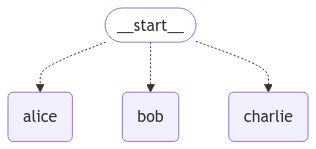

In [27]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [36]:
for chunk in graph.stream({"messages": [("user", "hi! transfer me to bob")]}, config):
    print(chunk)
    print("\n")

{'alice': {'messages': [HumanMessage(content="Transferred to 'bob'!", additional_kwargs={}, response_metadata={}, id='6139789a-4edc-4e29-bd75-56f62746cb21')], 'node': 'bob'}}




In [37]:
for chunk in graph.stream({"messages": [("user", "transfer me to charlie")]}, config):
    print(chunk)
    print("\n")

{'bob': {'messages': [HumanMessage(content="Transferred to 'charlie'!", additional_kwargs={}, response_metadata={}, id='43e15185-ea2f-49ac-95d9-ed6bfdd20948')], 'node': 'charlie'}}




In [38]:
for chunk in graph.stream({"messages": [("user", "back to bob please")]}, config):
    print(chunk)
    print("\n")

{'charlie': {'messages': [HumanMessage(content="Transferred back to 'bob'! How can I assist you today?", additional_kwargs={}, response_metadata={}, id='d169666e-a5e6-4c9c-abe0-6bc7400e3ee3')], 'node': 'charlie'}}




---

### Supervisor

In [51]:
builder = StateGraph(AgentRouterState)

supervisor_tool = create_handoff_tool("supervisor", name="transfer_to_supervisor")

supervisor = make_agent_node(model_anthropic, [alice_tool, bob_tool], state_modifier=(
    "You're team supervisor managing Alice and Bob. "
    "Alice is an expert at multiplication, Bob is great at addition. "
    "To answer user question, transfer to one of them that has the requisite skills. "
    "Once you have the final answer to user question, do not transfer -- respond to user directly!"
))
bob = make_agent_node(model_anthropic, [add, supervisor_tool], state_modifier="You're Bob. Once you're done adding, you MUST call supervisor.")
alice = make_agent_node(model_anthropic, [multiply, supervisor_tool], state_modifier="You're Alice. Once you're done multiplying, you MUST call supervisor.")

add_entrypoint_router(builder, route_to=[("supervisor", supervisor), ("alice", alice), ("bob", bob)], default_start_node="supervisor")

# this just doesn't make any sense because requires manually running every step (ie looping yourself) OR adding crazy conditional edges
def route_from_node(state, config):
    last_active_node = config["metadata"]["langgraph_node"]
    goto_node = state.get("node")
    if last_active_node == goto_node:
        return "__end__"

    return goto_node

builder.add_conditional_edges("supervisor", route_from_node)
builder.add_conditional_edges("alice", route_from_node)
builder.add_conditional_edges("bob", route_from_node)

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

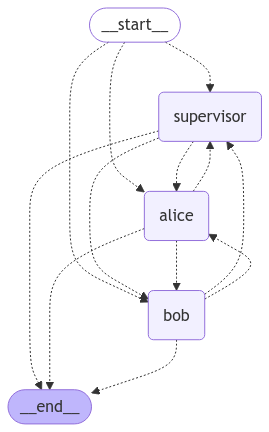

In [52]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [53]:
for chunk in graph.stream({"messages": [("user", "what's 391 + 193")]}, config, subgraphs=True):
    print(chunk)
    print("\n")

(('supervisor:f58be38e-f1a2-bbcb-9ad6-c83c335782b1',), {'agent': {'messages': [AIMessage(content=[{'text': "Since this is an addition problem, I'll transfer to Bob who specializes in addition.", 'type': 'text'}, {'id': 'toolu_01FhsG3FMCLYfEaK6gr7bKG1', 'input': {}, 'name': 'transfer_to_bob', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_016CohLgdQVFm4GhB3svtSc2', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'input_tokens': 481, 'output_tokens': 57}}, id='run-7f647901-80d7-4de6-b8d8-4e5feff62377-0', tool_calls=[{'name': 'transfer_to_bob', 'args': {}, 'id': 'toolu_01FhsG3FMCLYfEaK6gr7bKG1', 'type': 'tool_call'}], usage_metadata={'input_tokens': 481, 'output_tokens': 57, 'total_tokens': 538, 'input_token_details': {}})]}})


(('supervisor:f58be38e-f1a2-bbcb-9ad6-c83c335782b1',), {'tools': {'messages': [ToolMessage(content="Transferred to 'bob'!", name='transfer_to_bob', id='b34f4a63-80c6-4a93-8aa0-ca64e7cf64

In [54]:
# this would be needed if we're running step-by-step w/o conditional edges

# for chunk in graph.stream({"messages": []}, config, subgraphs=True):
#     print(chunk)
#     print("\n")

In [55]:
graph.get_state(config).values["messages"]

[HumanMessage(content="what's 391 + 193", additional_kwargs={}, response_metadata={}, id='fe42043c-b1d8-4ce2-b937-3245ab651ae2'),
 AIMessage(content=[{'text': "Since this is an addition problem, I'll transfer to Bob who specializes in addition.", 'type': 'text'}, {'id': 'toolu_01FhsG3FMCLYfEaK6gr7bKG1', 'input': {}, 'name': 'transfer_to_bob', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_016CohLgdQVFm4GhB3svtSc2', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'input_tokens': 481, 'output_tokens': 57}}, id='run-7f647901-80d7-4de6-b8d8-4e5feff62377-0', tool_calls=[{'name': 'transfer_to_bob', 'args': {}, 'id': 'toolu_01FhsG3FMCLYfEaK6gr7bKG1', 'type': 'tool_call'}], usage_metadata={'input_tokens': 481, 'output_tokens': 57, 'total_tokens': 538, 'input_token_details': {}}),
 ToolMessage(content="Transferred to 'bob'!", name='transfer_to_bob', id='b34f4a63-80c6-4a93-8aa0-ca64e7cf6457', tool_call_id='toolu_01FhsG

In [56]:
graph.get_state(config).values["messages"][-1]

AIMessage(content='The answer to your addition problem is 584.', additional_kwargs={}, response_metadata={'id': 'msg_019d4AUeHWcqKLCvUNXDaBw9', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'input_tokens': 738, 'output_tokens': 14}}, id='run-69d6b951-1b4d-43eb-96d8-8b2c053a51ab-0', usage_metadata={'input_tokens': 738, 'output_tokens': 14, 'total_tokens': 752, 'input_token_details': {}})

---

### Network

In [64]:
alice = make_agent_node(model_anthropic, [multiply, bob_tool], state_modifier="You're Alice, a multiplication expert. You can ask Bob for help with addition.")
bob = make_agent_node(model_anthropic, [add, alice_tool], state_modifier="You're Bob, an addition expert. You can ask Alice for help with muiltiplication.")

builder = StateGraph(AgentRouterState)
add_entrypoint_router(builder, route_to=[("alice", alice), ("bob", bob)], default_start_node="alice")
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

In [65]:
config = {"configurable": {"thread_id": "1"}}

In [66]:
for chunk in graph.stream({"messages": [("user", "what's 2 + 3")]}, config, subgraphs=True):
    print(chunk)

(('alice:7bab2927-85e4-934a-d98b-88603572db69',), {'agent': {'messages': [AIMessage(content=[{'text': "Since I'm Alice and I specialize in multiplication, not addition, I'll need to transfer this question to Bob who can help with addition.", 'type': 'text'}, {'id': 'toolu_01BvELp3WNftHMCxaATP3Gkq', 'input': {}, 'name': 'transfer_to_bob', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01FC32BFRbjTSWWa28KtF2i6', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'input_tokens': 457, 'output_tokens': 68}}, id='run-01f121eb-e0c9-48a9-8b6c-a0a4e3329aaf-0', tool_calls=[{'name': 'transfer_to_bob', 'args': {}, 'id': 'toolu_01BvELp3WNftHMCxaATP3Gkq', 'type': 'tool_call'}], usage_metadata={'input_tokens': 457, 'output_tokens': 68, 'total_tokens': 525, 'input_token_details': {}})]}})
(('alice:7bab2927-85e4-934a-d98b-88603572db69',), {'tools': {'messages': [ToolMessage(content="Transferred to 'bob'!", name='transfer_to_bob'

In [67]:
# extra call
for chunk in graph.stream({"messages": []}, config, subgraphs=True):
    print(chunk)

(('bob:5f9c1b93-55b7-7e17-7df4-6e73a0141c10',), {'agent': {'messages': [AIMessage(content=[{'text': "Hi! This is Bob. I'm an addition expert and I'll help you with adding 2 + 3.", 'type': 'text'}, {'id': 'toolu_01FtbxY4AEok86vBWuFFuJmR', 'input': {'a': 2, 'b': 3}, 'name': 'add', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01MssqdAKEo8ZkHAuVSCtSUN', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'input_tokens': 545, 'output_tokens': 95}}, id='run-4c58aebb-25aa-4af0-8cfb-f8571a426d76-0', tool_calls=[{'name': 'add', 'args': {'a': 2, 'b': 3}, 'id': 'toolu_01FtbxY4AEok86vBWuFFuJmR', 'type': 'tool_call'}], usage_metadata={'input_tokens': 545, 'output_tokens': 95, 'total_tokens': 640, 'input_token_details': {}})]}})
(('bob:5f9c1b93-55b7-7e17-7df4-6e73a0141c10',), {'tools': {'messages': [ToolMessage(content='5', name='add', id='ca20a888-dcd4-4856-ad41-2ee931905532', tool_call_id='toolu_01FtbxY4AEok86vBWuFFuJmR')]

In [68]:
for chunk in graph.stream({"messages": [("user", "now multiply that by 11")]}, config, subgraphs=True):
    print(chunk)

(('bob:fd9a8ff9-2f3e-9e0e-62c6-e6a81d552ee3',), {'agent': {'messages': [AIMessage(content=[{'text': "Since I'm Bob and I specialize in addition, not multiplication, I'll need to transfer this to Alice who can help with multiplication.", 'type': 'text'}, {'id': 'toolu_01CJ8iedUZVzAe2KhSTQxBuK', 'input': {}, 'name': 'transfer_to_alice', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01JcEHahcMCxnahWmpS2K8TM', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'input_tokens': 679, 'output_tokens': 67}}, id='run-53676875-68a0-4325-8b54-a7a675592641-0', tool_calls=[{'name': 'transfer_to_alice', 'args': {}, 'id': 'toolu_01CJ8iedUZVzAe2KhSTQxBuK', 'type': 'tool_call'}], usage_metadata={'input_tokens': 679, 'output_tokens': 67, 'total_tokens': 746, 'input_token_details': {}})]}})
(('bob:fd9a8ff9-2f3e-9e0e-62c6-e6a81d552ee3',), {'tools': {'messages': [ToolMessage(content="Transferred to 'alice'!", name='transfer_to_alice

In [69]:
for chunk in graph.stream({"messages": []}, config, subgraphs=True):
    print(chunk)

(('alice:40f9195d-6eaa-8ef9-1d29-8ecd9051807b',), {'agent': {'messages': [AIMessage(content=[{'text': "Hi! This is Alice. I'll help you multiply 5 by 11.", 'type': 'text'}, {'id': 'toolu_01415cUu4yCe2Yn6KwjvpZ6u', 'input': {'a': 5, 'b': 11}, 'name': 'multiply', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01EwxXRNSG4UzhwFtCVjwnUQ', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'input_tokens': 762, 'output_tokens': 88}}, id='run-7eb79b04-a3ae-4514-8ef7-f770ce776896-0', tool_calls=[{'name': 'multiply', 'args': {'a': 5, 'b': 11}, 'id': 'toolu_01415cUu4yCe2Yn6KwjvpZ6u', 'type': 'tool_call'}], usage_metadata={'input_tokens': 762, 'output_tokens': 88, 'total_tokens': 850, 'input_token_details': {}})]}})
(('alice:40f9195d-6eaa-8ef9-1d29-8ecd9051807b',), {'tools': {'messages': [ToolMessage(content='55', name='multiply', id='03685341-fe32-44c7-a5fb-c60735ec9955', tool_call_id='toolu_01415cUu4yCe2Yn6KwjvpZ6u')]}})


In [70]:
graph.get_state(config).values["messages"]

[HumanMessage(content="what's 2 + 3", additional_kwargs={}, response_metadata={}, id='df3ea9d6-7bd8-490e-a8c9-ab252c2314d2'),
 AIMessage(content=[{'text': "Since I'm Alice and I specialize in multiplication, not addition, I'll need to transfer this question to Bob who can help with addition.", 'type': 'text'}, {'id': 'toolu_01BvELp3WNftHMCxaATP3Gkq', 'input': {}, 'name': 'transfer_to_bob', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01FC32BFRbjTSWWa28KtF2i6', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'input_tokens': 457, 'output_tokens': 68}}, id='run-01f121eb-e0c9-48a9-8b6c-a0a4e3329aaf-0', tool_calls=[{'name': 'transfer_to_bob', 'args': {}, 'id': 'toolu_01BvELp3WNftHMCxaATP3Gkq', 'type': 'tool_call'}], usage_metadata={'input_tokens': 457, 'output_tokens': 68, 'total_tokens': 525, 'input_token_details': {}}),
 ToolMessage(content="Transferred to 'bob'!", name='transfer_to_bob', id='d179d756-6f41-4cd

---

### Different state schema in parent vs child state

In [19]:
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage
from typing import Annotated, TypedDict

In [20]:
class CustomParentState(TypedDict):
    # deliberately use a different key here
    parent_messages: Annotated[list[BaseMessage], add_messages]
    node: str

In [21]:
def input_processor(state):
    return {**state, "messages": state["parent_messages"]}

def output_processor(state):
    updated_state = keep_last_message_as_human(state)
    return {**updated_state, "parent_messages": updated_state["messages"]}

In [22]:
alice = make_agent_node(
    model_anthropic,
    [multiply, bob_tool],
    input_processor=input_processor,
    output_processor=output_processor,
    state_modifier="You're Alice, a multiplication expert. You can ask Bob for help with addition."
)
bob = make_agent_node(
    model_anthropic,
    [add, alice_tool],
    input_processor=input_processor,
    output_processor=output_processor,
    state_modifier="You're Bob, an addition expert. You can ask Alice for help with muiltiplication."
)

builder = StateGraph(CustomParentState)
add_entrypoint_router(builder, route_to=[("alice", alice), ("bob", bob)], default_start_node="alice")
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

In [23]:
config = {"configurable": {"thread_id": "1"}}

In [100]:
for chunk in graph.stream({"parent_messages": [("user", "what's 2 + 3")]}, config, subgraphs=True):
    print(chunk)

(('alice:f6ef16c4-e48d-6de0-8a66-076db6b25e2b',), {'agent': {'messages': [AIMessage(content=[{'text': 'As Alice, I specialize in multiplication, but not addition. Let me transfer this question to Bob who can help with addition.', 'type': 'text'}, {'id': 'toolu_018rT2G9eyprmkhucyD7Yvvf', 'input': {}, 'name': 'transfer_to_bob', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01U71DztgJjRYC1Ca834xusM', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'input_tokens': 457, 'output_tokens': 65}}, id='run-211da428-576e-4733-90dc-193fb56c0214-0', tool_calls=[{'name': 'transfer_to_bob', 'args': {}, 'id': 'toolu_018rT2G9eyprmkhucyD7Yvvf', 'type': 'tool_call'}], usage_metadata={'input_tokens': 457, 'output_tokens': 65, 'total_tokens': 522, 'input_token_details': {}})]}})
(('alice:f6ef16c4-e48d-6de0-8a66-076db6b25e2b',), {'tools': {'messages': [ToolMessage(content="Transferred to 'bob'!", name='transfer_to_bob', id='695627

In [101]:
for chunk in graph.stream({"parent_messages": []}, config, subgraphs=True):
    print(chunk)

(('bob:51eb5ae0-8ab5-a015-62c2-f4c07a3b32dd',), {'agent': {'messages': [AIMessage(content=[{'text': 'I can help you add 2 and 3! Let me use the add function.', 'type': 'text'}, {'id': 'toolu_01C7yeptGHGYEiKpNkHY84pm', 'input': {'a': 2, 'b': 3}, 'name': 'add', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01K2GC9iSxASCeQ9J6XT9L31', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'input_tokens': 467, 'output_tokens': 88}}, id='run-6af37d8d-eda5-4147-b52f-5c0b18fe8bf8-0', tool_calls=[{'name': 'add', 'args': {'a': 2, 'b': 3}, 'id': 'toolu_01C7yeptGHGYEiKpNkHY84pm', 'type': 'tool_call'}], usage_metadata={'input_tokens': 467, 'output_tokens': 88, 'total_tokens': 555, 'input_token_details': {}})]}})
(('bob:51eb5ae0-8ab5-a015-62c2-f4c07a3b32dd',), {'tools': {'messages': [ToolMessage(content='5', name='add', id='8df91d77-8db1-45be-bb55-b8acbbafa2bc', tool_call_id='toolu_01C7yeptGHGYEiKpNkHY84pm')]}})
(('bob:51eb5ae0-

In [102]:
graph.get_state(config).values.keys()

dict_keys(['parent_messages', 'node'])

In [103]:
graph.get_state(config).values["parent_messages"]

[HumanMessage(content="what's 2 + 3", additional_kwargs={}, response_metadata={}, id='f13151d6-2712-4003-9372-ed4c78ef2113'),
 HumanMessage(content="Transferred to 'bob'!", additional_kwargs={}, response_metadata={}, id='1882dc46-4f2c-488c-bb43-539071161b3f'),
 HumanMessage(content='2 + 3 = 5!', additional_kwargs={}, response_metadata={}, id='9d8c90a4-9b66-471c-ab22-3ef50e67335a')]

### Tools that update state (externally)

In [24]:
class CustomParentState(TypedDict):
    # deliberately use a different key here
    parent_messages: Annotated[list[BaseMessage], add_messages]
    node: str
    user_name: str

In [25]:
from langchain_core.tools import tool

In [26]:
@tool(response_format="content_and_artifact", return_direct=True)
def get_user_name():
    """Retrieve user name"""
    return "Successfully retrieved user name", GraphCommand(update={"user_name": "Meow"})

In [32]:
def input_processor(state):
    return {**state, "messages": state["parent_messages"]}

def output_processor(state):
    state = keep_last_message_as_human(state)
    return {**state, "parent_messages": state["messages"]}

In [33]:
alice = make_agent_node(
    model,
    [get_user_name],
    input_processor=input_processor,
    output_processor=output_processor,
)

builder = StateGraph(CustomParentState)
builder.add_node("alice", alice)
builder.add_edge(START, "alice")
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

In [34]:
config = {"configurable": {"thread_id": "1"}}

In [35]:
for chunk in graph.stream({"parent_messages": [("user", "get user name")]}, config):
    print(chunk)

{'alice': {'parent_messages': [HumanMessage(content='Successfully retrieved user name', additional_kwargs={}, response_metadata={}, id='c8a26619-7803-4ab7-b0b1-f924b187a771')], 'user_name': 'Meow'}}


In [36]:
graph.get_state(config).values

{'parent_messages': [HumanMessage(content='get user name', additional_kwargs={}, response_metadata={}, id='0c4c298e-d55d-4614-9ee2-00176941641f'),
  HumanMessage(content='Successfully retrieved user name', additional_kwargs={}, response_metadata={}, id='c8a26619-7803-4ab7-b0b1-f924b187a771')],
 'user_name': 'Meow'}

### Tools that update state (internally)

In [39]:
class CustomState(AgentRouterState):
    user_name: str

In [40]:
from langchain_core.tools import tool

In [41]:
@tool(response_format="content_and_artifact", return_direct=True)
def get_user_name():
    """Retrieve user name"""
    return "Successfully retrieved user name", GraphCommand(update={"user_name": "Meow"})

In [42]:
def state_modifier(state):
    user_name = state.get("user_name")
    if user_name is None:
        return state["messages"]

    system_msg = f"User name is {user_name}"
    return [{"role": "system", "content": system_msg}] + state["messages"]

In [43]:
checkpointer = MemorySaver()
test_agent = create_react_agent(model, [get_user_name], state_schema=CustomState, state_modifier=state_modifier, checkpointer=checkpointer)

In [44]:
config = {"configurable": {"thread_id": "1"}}

In [45]:
test_agent.invoke({"messages": [("user", "hi -- please get the user name")]}, config)

{'messages': [HumanMessage(content='hi -- please get the user name', additional_kwargs={}, response_metadata={}, id='786fed4c-dca3-4fa0-adc5-fcd4b0efa0c7'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_DY1q6xNuUl4l5H8GOXthXRfL', 'function': {'arguments': '{}', 'name': 'get_user_name'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 43, 'total_tokens': 54, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_45cf54deae', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-2fd78c26-a054-4feb-a883-a51f0733d13f-0', tool_calls=[{'name': 'get_user_name', 'args': {}, 'id': 'call_DY1q6xNuUl4l5H8GOXthXRfL', 'type': 'tool_call'}], usage_metadata={'input_tokens': 43, 'output_tokens': 11

In [46]:
test_agent.invoke({"messages": [("user", "whats my name")]}, config)

{'messages': [HumanMessage(content='hi -- please get the user name', additional_kwargs={}, response_metadata={}, id='786fed4c-dca3-4fa0-adc5-fcd4b0efa0c7'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_DY1q6xNuUl4l5H8GOXthXRfL', 'function': {'arguments': '{}', 'name': 'get_user_name'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 43, 'total_tokens': 54, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_45cf54deae', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-2fd78c26-a054-4feb-a883-a51f0733d13f-0', tool_calls=[{'name': 'get_user_name', 'args': {}, 'id': 'call_DY1q6xNuUl4l5H8GOXthXRfL', 'type': 'tool_call'}], usage_metadata={'input_tokens': 43, 'output_tokens': 11

---

### Test interrupts from inside tools

TL;DR works w/ a single graph, doesn't work w/ subgraphs

In [79]:
from langgraph.types import interrupt, Command

In [80]:
@tool(response_format="content_and_artifact")  #, return_direct=True)
def get_user_name():
    """Retrieve user name"""
    user_name = interrupt("Please provider user name")
    return "Successfully retrieved user name", GraphCommand(update={"user_name": user_name})

In [81]:
def state_modifier(state):
    user_name = state.get("user_name")
    if user_name is None:
        return state["messages"]

    system_msg = f"User name is {user_name}"
    return [{"role": "system", "content": system_msg}] + state["messages"]

In [89]:
test_agent = make_agent_node(model, [get_user_name], state_schema=CustomState, state_modifier=state_modifier)

builder = StateGraph(CustomState)
builder.add_node("agent", test_agent)
builder.add_edge(START, "agent")
checkpointer = MemorySaver()
graph = builder.compile(checkpointer=checkpointer)

In [90]:
# checkpointer = MemorySaver()
# test_agent = create_react_agent(model, [get_user_name], checkpointer=checkpointer)

In [92]:
graph.invoke({"messages": [("user", "hi -- please get the user name")]}, config)

{'messages': [HumanMessage(content='hi -- please get the user name', additional_kwargs={}, response_metadata={}, id='5b4f9de3-13d3-4d1e-963d-e1b8b80dea96')]}

In [94]:
graph.get_state(config).tasks

(PregelTask(id='54922a05-cd7e-3094-ebe0-e55eb21bf24e', name='agent', path=('__pregel_pull', 'agent'), error=None, interrupts=(Interrupt(value='Please provider user name', resumable=True, ns=['agent:54922a05-cd7e-3094-ebe0-e55eb21bf24e', 'tools:d70d2003-c7b7-06fe-faf1-0ee3731a77f2'], when='during'),), state={'configurable': {'thread_id': '1', 'checkpoint_ns': 'agent:54922a05-cd7e-3094-ebe0-e55eb21bf24e'}}, result=None),)

In [96]:
# graph.invoke(Command(resume="Archibald"), config)

In [88]:
test_agent.invoke({"messages": [("user", "whats my name")]}, config)

{'messages': [HumanMessage(content='hi -- please get the user name', additional_kwargs={}, response_metadata={}, id='3662d0e1-7f5b-4a39-b8fb-d114d69c5138'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_KJah0Kamn5i3Gk8v8qaBukCR', 'function': {'arguments': '{}', 'name': 'get_user_name'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 43, 'total_tokens': 54, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_62f96df568', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-d5cf2ceb-5417-4c57-9955-059cd1d84c9e-0', tool_calls=[{'name': 'get_user_name', 'args': {}, 'id': 'call_KJah0Kamn5i3Gk8v8qaBukCR', 'type': 'tool_call'}], usage_metadata={'input_tokens': 43, 'output_tokens': 11

---